In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import cv2
!pip install mat73


Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import urllib.request
from tqdm import tqdm

url = 'http://horatio.cs.nyu.edu/mit/silberman/nyu_depth_v2/nyu_depth_v2_labeled.mat'
filename = 'nyu_depth_v2_labeled.mat'
save_directory = r'C:\Users\ee20m\Documents'  # Replace 'YourUsername' with your actual username

# Check if the file already exists in the save directory
if not os.path.exists(os.path.join(save_directory, filename)):
    # Get the file size
    file_size = int(urllib.request.urlopen(url).info().get('Content-Length', -1))

    # Download the file with progress bar
    with tqdm(unit='B', unit_scale=True, unit_divisor=1024, miniters=1, desc=filename, total=file_size) as pbar:
        urllib.request.urlretrieve(url, os.path.join(save_directory, filename), reporthook=lambda blocks, block_size, total_size: pbar.update(block_size))
else:
    print(f"File '{filename}' already exists in the save directory.")

# After downloading, the file will be saved in the specified directory (e.g., 'C:\Users\YourUsername\Documents').


File 'nyu_depth_v2_labeled.mat' already exists in the save directory.


In [3]:
import h5py

# Specify the path to the .mat file
file_path = r'C:\Users\ee20m\Documents\nyu_depth_v2_labeled.mat'

# Load the data from the .mat file using h5py
with h5py.File(file_path, 'r') as f:
    # Get the key names
    keys = list(f.keys())

# Print the key names
for key in keys:
    print(key)


#refs#
#subsystem#
accelData
depths
images
instances
labels
names
namesToIds
rawDepthFilenames
rawDepths
rawRgbFilenames
sceneTypes
scenes


In [4]:
import h5py

# Specify the path to the .mat file
file_path = r'C:\Users\ee20m\Documents\nyu_depth_v2_labeled.mat'

# Load the data from the .mat file using h5py
with h5py.File(file_path, 'r') as f:
    left_images = np.array(f['images'])
    right_images = np.array(f['rawRgbFilenames'])
    depths = np.array(f['depths'])


In [5]:
# Get the size or shape of the arrays
left_images_shape = left_images.shape
right_images_shape = right_images.shape
depths_shape = depths.shape

print("Size of left_images:", left_images_shape)
print("Size of right_images:", right_images_shape)
print("Size of depths:", depths_shape)

Size of left_images: (1449, 3, 640, 480)
Size of right_images: (1, 1449)
Size of depths: (1449, 640, 480)


In [ ]:
import numpy as np
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Load the stereo pair data
left_images = np.load('stereo_pairs_left.npy')
right_images = np.load('stereo_pairs_right.npy')

# Normalize the input data
left_images = left_images.astype('float32') / 255.0
right_images = right_images.astype('float32') / 255.0

# Define the input shape
input_shape = left_images.shape[1:]

# Encoder
inputs_left = Input(shape=input_shape)
inputs_right = Input(shape=input_shape)

conv1_left = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs_left)
conv1_right = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs_right)

concatenated = Concatenate()([conv1_left, conv1_right])

pool1 = MaxPooling2D((2, 2), padding='same')(concatenated)
conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

# Decoder
conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
up1 = UpSampling2D((2, 2))(conv3)
conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv4)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)

# Create the autoencoder model
autoencoder = Model([inputs_left, inputs_right], decoded)

# Define the photometric loss
def photometric_loss(y_true, y_pred):
    reconstructed_left = K.concatenate([y_pred, inputs_right], axis=-1)
    return K.mean(K.abs(inputs_left - reconstructed_left))

# Compile the model with the photometric loss
autoencoder.compile(optimizer='adam', loss=photometric_loss)

# Print the model summary
autoencoder.summary()

# Train the model
history = autoencoder.fit([left_images, right_images], left_images, batch_size=8, epochs=100, validation_split=0.2)

# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [4]:
X.shape,y.shape

((1449, 640, 480, 3), (1449, 640, 480))

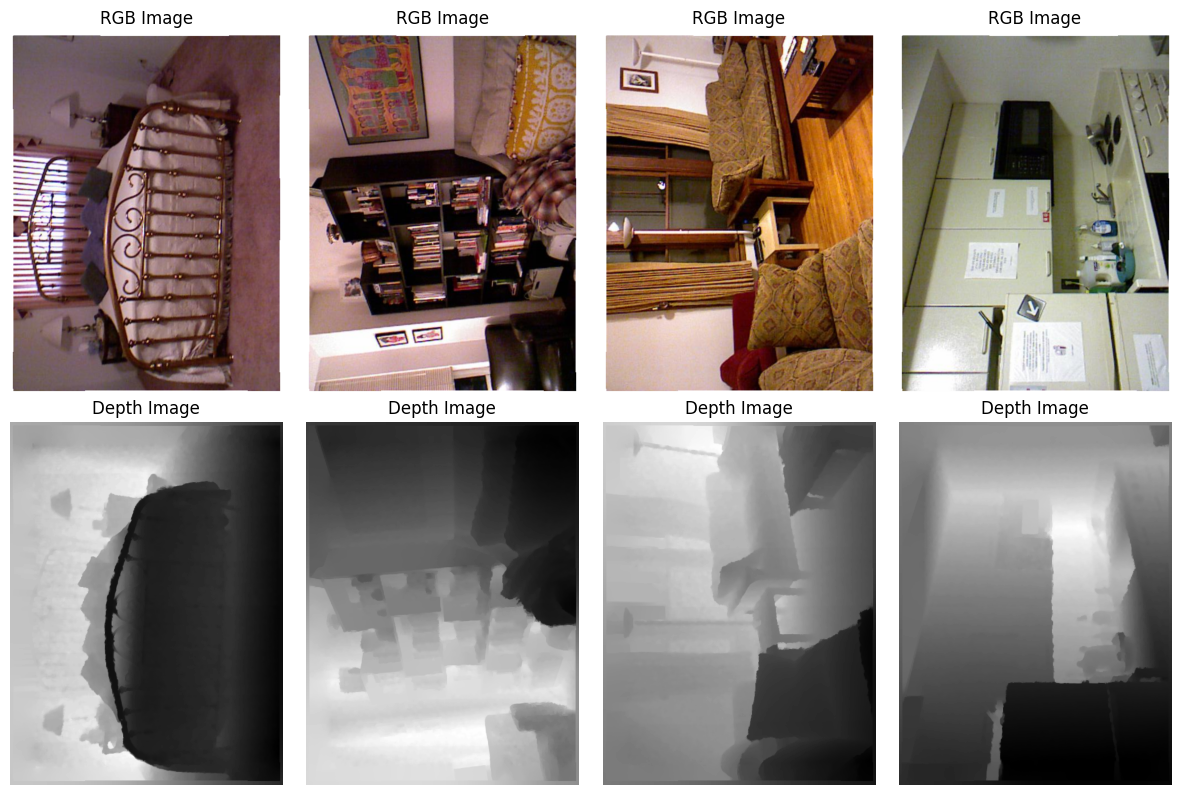

In [5]:
import matplotlib.pyplot as plt

# Display random images from X with corresponding depth images from y
num_images = 4
random_indices = np.random.choice(X.shape[0], num_images, replace=False)

plt.figure(figsize=(12, 8))
for i, index in enumerate(random_indices):
    # Display RGB image
    plt.subplot(2, num_images, i + 1)
    rgb_image = X[index]
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title('RGB Image')

    # Display Depth image
    plt.subplot(2, num_images, num_images + i + 1)
    depth_image = y[index]
    plt.imshow(depth_image, cmap='gray')
    plt.axis('off')
    plt.title('Depth Image')

plt.tight_layout()
plt.show()


In [6]:
import cv2
import numpy as np

# Reshape X and y to the desired shape
X_resized = np.zeros((X.shape[0], 320, 160, 3))
y_resized = np.zeros((y.shape[0], 320, 160))

for i in range(X.shape[0]):
    X_resized[i] = cv2.resize(X[i], (160, 320))
    y_resized[i] = cv2.resize(y[i], (160, 320))


In [7]:
X_resized.shape,y_resized.shape

((1449, 320, 160, 3), (1449, 320, 160))

In [8]:
pip install scikit-learn


Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_resized, y_resized, test_size=0.2, random_state=42)

print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)


(1159, 320, 160, 3) (1159, 320, 160)
(290, 320, 160, 3) (290, 320, 160)


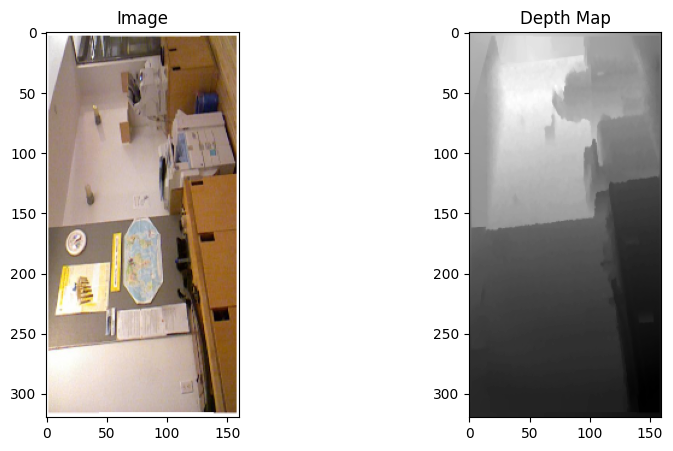

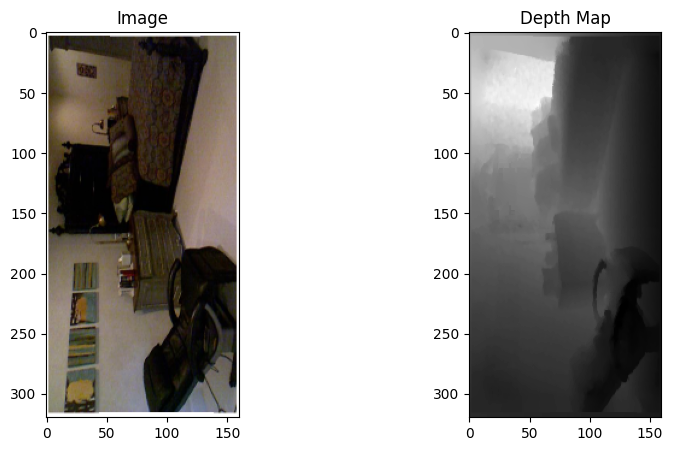

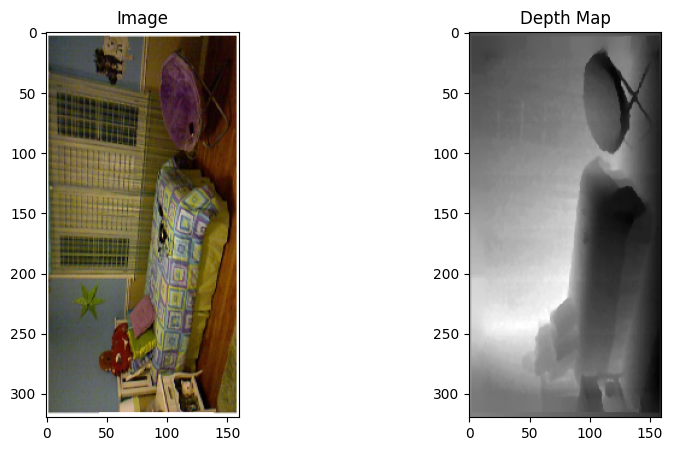

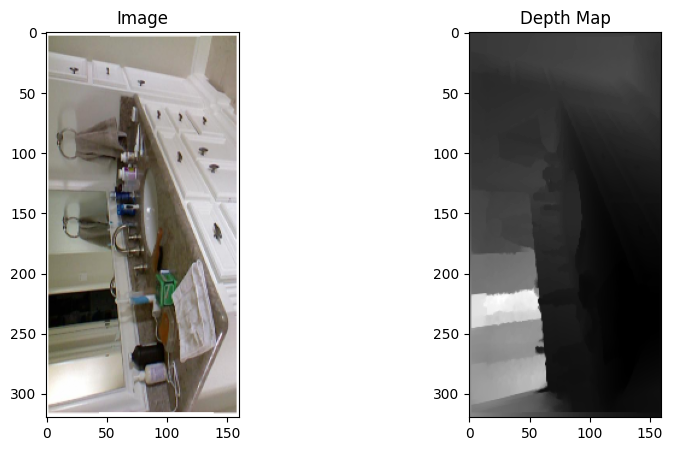

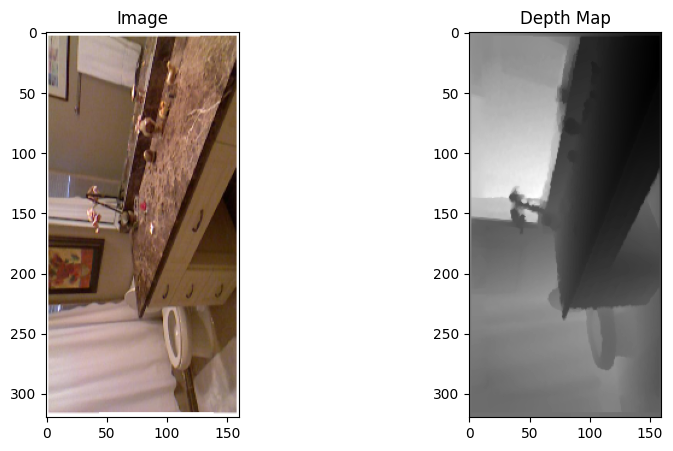

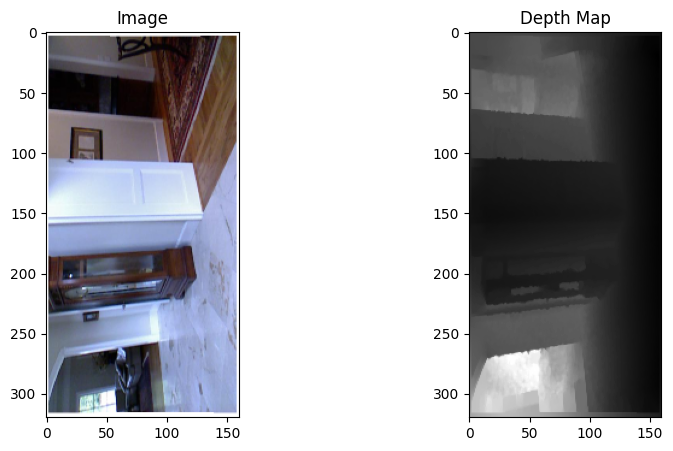

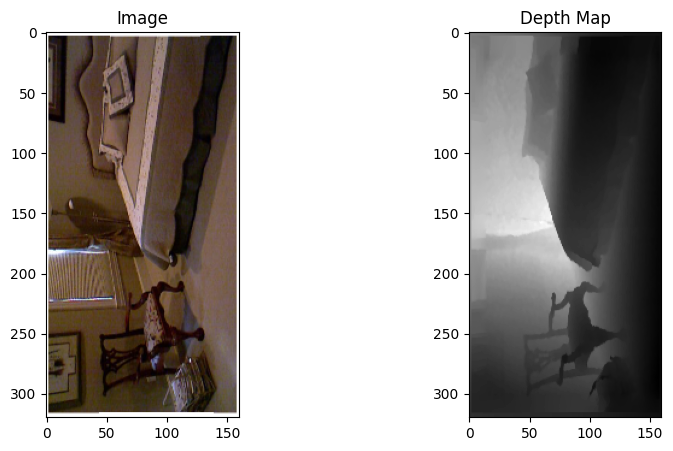

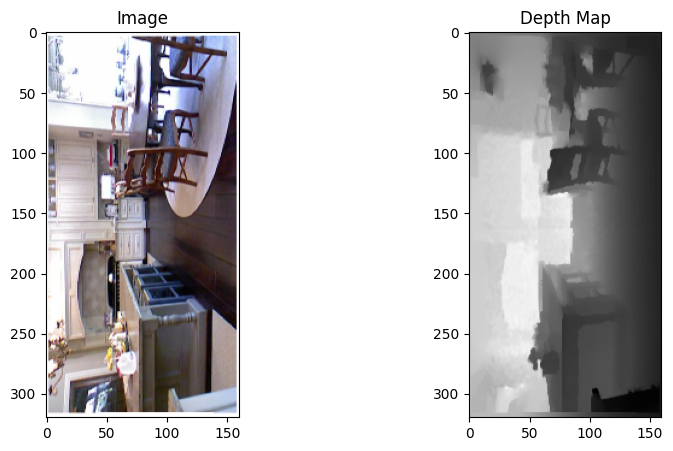

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# define a function to visualize an image with its corresponding depth map
def visualize_image_and_depth_map(X, y):
    # choose a random index
    idx = np.random.randint(X.shape[0])
    # get the image and depth map at that index
    image = X[idx]
    depth_map = y[idx]
    # normalize the pixel values to be between 0 and 1
    image = image / 255.0
    depth_map = depth_map / np.max(depth_map)
    # plot the image and depth map side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[1].imshow(depth_map, cmap='gray')
    ax[1].set_title('Depth Map')
    plt.show()


# visualize 4 random images from X_train
for i in range(4):
    visualize_image_and_depth_map(X_train, y_train)

# visualize 4 random images from X_val
for i in range(4):
    visualize_image_and_depth_map(X_val, y_val)


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

# Define the input shape
input_shape = (320, 160, 3)

# Encoder
inputs = Input(shape=input_shape)
conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
pool1 = MaxPooling2D((2, 2), padding='same')(conv1)
conv2 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool1)
pool2 = MaxPooling2D((2, 2), padding='same')(conv2)

# Decoder
conv3 = Conv2D(8, (3, 3), activation='relu', padding='same')(pool2)
up1 = UpSampling2D((2, 2))(conv3)
conv4 = Conv2D(16, (3, 3), activation='relu', padding='same')(up1)
up2 = UpSampling2D((2, 2))(conv4)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2)

# Create the autoencoder model
autoencoder = Model(inputs, decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mse')

# Print the model summary
#autoencoder.summary()

# Train the model
history = autoencoder.fit(X_train, X_train, batch_size=8, epochs=100, validation_data=(X_val, X_val))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/100
145/145 [==============================] - 139s 927ms/step - loss: 17625.7266 - val_loss: 17756.8164
Epoch 2/100
 86/145 [================>.............] - ETA: 47s - loss: 17669.8320

KeyboardInterrupt: 